In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.special import erf
from scipy.special import hyp1f1
from scipy.linalg import eigh
from random import randint
from scipy.optimize import fsolve
from scipy.optimize import root
from numpy.polynomial import legendre

## simulation

In [26]:
def intensity(t,history,parameters):    #left continue, phi(tau)=1/4 sin(tau) 0<tau<pi
    mu=parameters[0]
    alpha=parameters[1]
    intensity=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        elif (t-history[i])<np.pi:
            intensity+=alpha*np.sin(t-history[i])
    return mu+intensity

In [27]:
def hawkes_simulation_sin(T,parameters):
    t=0
    points_homo=[]
    points_hawkes=[]
    intensity_sup=parameters[0]
    while(t<T):
        points_homo.append(t)
        r=expon.rvs(scale=1/intensity_sup) #scale=1/lamda
        t+=r
        D=uniform.rvs(loc=0,scale=1)
        if D*intensity_sup<=intensity(t,points_hawkes,parameters):
            points_hawkes.append(t)
            intensity_sup=intensity(t,points_hawkes,parameters)+parameters[1]
    if points_hawkes[-1]>T:
        del points_hawkes[-1]
    del points_homo[0]
    return points_hawkes

In [297]:
T=100

In [506]:
points_hawkes=[]

In [507]:
for i in range(10):
    points_hawkes.append(hawkes_simulation_sin(T,[1,0.25]))

In [508]:
len(points_hawkes)

10

In [509]:
def negtiveloglikelyhood1(parameters, times, T): #times=timestamp t1-tn; T is timespan      fast:R(i)
    times=np.array(times)
    
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    
    timedifference=T-times #T-t0...T-t(n-1) 
    timeexponential=np.exp(-beta*timedifference)-1
    secondsum=alpha/beta*sum(timeexponential)
    
    R=np.zeros((len(times),1))
    for i in range(1,len(times)):
        R[i]=np.exp(-beta*(times[i]-times[i-1]))*(1+R[i-1])
    firstsum=sum(np.log(mu+alpha*R))  #left-continuous
    
    negtivelogl=-(firstsum-mu*T+secondsum)
    return negtivelogl

In [517]:
res=[]

In [518]:
for i in range(10):
    parameters=np.array([1.2,0.7,3])
    result=optimize.minimize(negtiveloglikelyhood1, parameters,args=(points_hawkes[i],T), method='SLSQP', bounds=((0.01,5),(0.01,5),(0.01,5)), options={'disp': True})
    res.append(result.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 68.13261852996898
            Iterations: 42
            Function evaluations: 236
            Gradient evaluations: 40
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.38132982228386
            Iterations: 15
            Function evaluations: 76
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 68.72140569869099
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 64.78904529787418
            Iterations: 15
            Function evaluations: 76
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 37.58555379550717
            Iterations: 21
            Function eval

In [519]:
res_ave=np.average(res,axis=0)

In [600]:
res_ave

array([1.19901363, 0.13731366, 1.60064114])

In [520]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [521]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [522]:
def u_generate(theta0,theta1,xi): # xi is inducing points, N(0,Sigma)
    N=len(xi)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov[j][i]=cov[i][j]
    return multivariate_normal([0]*N,cov).rvs(),np.array([0]*N),cov

In [523]:
T_phi=6

In [524]:
xi=np.linspace(0,T_phi,10)   # 10 inducing points on \phi(\tau)

In [525]:
theta0=0.05
theta1=4

In [526]:
u,mean_p_u,cov_p_u=u_generate(theta0,theta1,xi)

In [527]:
f=GP_regression(xi,u,theta0,theta1,0.000001,T_phi,100) # f is 100-dimension vector on [0,T_phi]

In [528]:
def ini_P(points_hawkes,T_phi):
    N=len(points_hawkes)
    P=np.zeros((N,N))
    for i in range(N):                    # initial value of P
        for j in range(i+1):
            tij=points_hawkes[i]-points_hawkes[j]
            if tij>=T_phi:continue
            else:
                P[i][j:i+1]=np.random.dirichlet([1]*(i-j+1))
                break
    return P

In [529]:
def psi(theta0,theta1,xn,xm,T):
    x_mean=(xn+xm)/2
    return (theta0**2)*(-np.sqrt(np.pi/theta1)/2)*np.exp((-theta1*(xn-xm)**2)/4)*(erf((x_mean-T)*np.sqrt(theta1))\
                                                                                  -erf(x_mean*np.sqrt(theta1)))

In [530]:
def distribution_f_posterior(x_f,xi,theta0,theta1,cov_p_u,cov_q_u_post):
    N=len(xi) # N is number of inducing points
    M=len(x_f) # M is number of predicting points
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    K_xz=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            K_xz[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],xi[j])
#     K_xx=np.zeros((M,M))
#     for i in range(M):
#         for j in range(i,M):
#             K_xx[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],x_f[j])
#             K_xx[j][i]=K_xx[i][j]
#     mean_f=(K_xz.dot(cov_p_u_inv)).dot(mean_q_u_post)
#     cov_f=K_xx-(K_xz.dot(cov_p_u_inv)).dot(K_xz.T)+(((K_xz.dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz.T)
    var_f=np.array([theta0-K_xz[i].dot(cov_p_u_inv).dot(K_xz[i].T)+(((K_xz[i].dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz[i].T) for i in range(M)])
    
    exp_phi=var_f
    return exp_phi

## \mu is constant

In [531]:
def eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for i in range(1,len(k_K_k)):
        for j in range(i):
            if P[i][j]!=0:
                y+=k_K_K_k[i][j][m]*P[i][j]/(k_K_k[i][j]+sum([(k_K[i][j][k]**2)*s[k] for k in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [532]:
def equations(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [533]:
def MISD_variational_deri_mu_cons(points_hawkes,xi,T_phi,T,num_iter): # 100 predict points on T_phi, 1000 predict points on T
    N=len(points_hawkes) # num of observation
    M=len(xi)            # num of inducing points on phi
    P=ini_P(points_hawkes,T_phi)
    delta_t=T_phi/len(f[0]) # phi is discete to 100 points
    
    #__________________initial setting of phi
    cov_q_u_diag=np.random.uniform(0,1,M)
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    thirdterm=np.diagonal(cov_p_u_inv)
    n_1=sum(np.array(points_hawkes)<(T-T_phi)) # num of points within T-T_phi
    Psi=np.zeros((N,M,M))
    for i in range(n_1):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T_phi)
                Psi[i][k][j]=Psi[i][j][k]
    for i in range(n_1,N):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T-points_hawkes[i])
                Psi[i][k][j]=Psi[i][j][k]
    secondterm=sum([np.diagonal(cov_p_u_inv.dot(Psi[i]).dot(cov_p_u_inv)) for i in range(N)])
    k_tn_z=np.zeros((N,N,M))
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                tao=points_hawkes[i]-points_hawkes[j]
                k_tn_z[i][j]=np.array([expo_quad_kernel(theta0,theta1,tao,xi[k]) for k in range(M)])            
    k_K_K_k=np.zeros((N,N,M))   # matrix of vector   #     1st term
    k_K_k=np.zeros((N,N))    # matrix of value
    k_K=np.zeros((N,N,M))     # matrix of vector
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                k_K_K_k[i][j]=np.diagonal(cov_p_u_inv.dot(np.array([k_tn_z[i][j]]).T).dot(np.array([k_tn_z[i][j]])).dot(cov_p_u_inv))
                k_K_k[i][j]=theta0-k_tn_z[i][j].dot(cov_p_u_inv).dot(k_tn_z[i][j].T)
                k_K[i][j]=k_tn_z[i][j].dot(cov_p_u_inv)
    
    
    
    
    
    for k in range(num_iter):  # num of iterations
        # update of phi
        
        cov_q_u_diag=fsolve(equations,cov_q_u_diag, args=(P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M))
        cov_q_u_diag[cov_q_u_diag<0] = 0.1 # more stable
        cov_q_u=np.diag(cov_q_u_diag)
        phi=distribution_f_posterior(f[0],xi,theta0,theta1,cov_p_u,cov_q_u)
        
        # update of mu
        
        mu=sum(np.diagonal(P))/T

        
        for i in range(N): # updata of P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: continue
                intensity_total+=phi[int(tji/delta_t)]
            intensity_total+=mu
            P[i][i]=mu/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: P[i][j]=0
                else: P[i][j]=phi[int(tji/delta_t)]/intensity_total
    return mu,phi

In [534]:
mu_var_list=[]
phi_var_list=[]

In [535]:
%%time
for i in range(10):
    mu_var,phi_var=MISD_variational_deri_mu_cons(points_hawkes[i],xi,T_phi,T,100)
    mu_var_list.append(mu_var)
    phi_var_list.append(phi_var)

C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Wall time: 1h 56min 28s


In [536]:
mu_var_ave=np.average(mu_var_list)

In [601]:
mu_var_list[4]

1.2395456638117874

In [537]:
phi_var_ave=np.average(phi_var_list,axis=0)

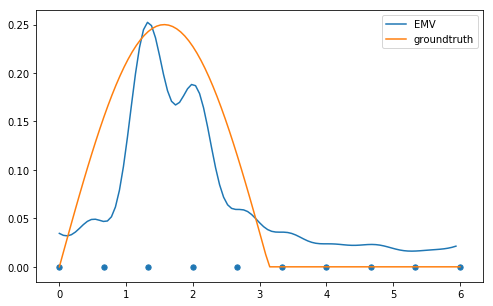

In [553]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(f[0],phi_var_list[4],label='EMV')
axs.plot(np.linspace(0,6,100),[0.25*np.sin(xxx) if xxx<np.pi else 0 for xxx in np.linspace(0,6,100) ],label='groundtruth')
axs.scatter(xi,np.zeros((len(xi))),marker='o',s=28)
plt.legend()
plt.show()

In [24]:
import pandas as pd
test=pd.DataFrame(data=points_hawkes)
test.to_csv('./case_3.csv',encoding='gbk')

## inference with full covariance matrix

In [302]:
def ELBO(theta0,theta1,xi,mean_p_u,cov_p_u,mean_q_u,cov_q_u,T,T_phi,points,P): # xi is inducing points
    assert len(mean_p_u)==len(mean_q_u)==len(xi)
    N=len(xi) # N is number of inducing points
    M=len(points) # M is number of observation
    
    fourth_term=-KL_gaussian(mean_q_u,cov_q_u,mean_p_u,cov_p_u)
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    n_1=sum(np.array(points)<(T-T_phi)) # num of points within T-T_phi
    
    Psi=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            Psi[i][j]=psi(theta0,theta1,xi[i],xi[j],T_phi)
            Psi[j][i]=Psi[i][j]
#     first_term=-np.matmul(np.matmul(np.matmul(np.matmul(mean_q_u,cov_p_u_inv),Psi),cov_p_u_inv),mean_q_u.T)*n_1
    second_term=-(theta0*T_phi-np.trace(np.matmul(cov_p_u_inv,Psi))\
                  +np.trace(np.matmul(np.matmul(np.matmul(cov_p_u_inv,cov_q_u),cov_p_u_inv),Psi)))*n_1
    for k in range(n_1,len(points)):
        Psi=np.zeros((N,N))
        for i in range(N):
            for j in range(i,N):
                Psi[i][j]=psi(theta0,theta1,xi[i],xi[j],T-points[k])
                Psi[j][i]=Psi[i][j]
#         first_term+=-np.matmul(np.matmul(np.matmul(np.matmul(mean_q_u,cov_p_u_inv),Psi),cov_p_u_inv),mean_q_u.T)
        second_term+=-(theta0*(T-points[k])-np.trace(np.matmul(cov_p_u_inv,Psi))\
                  +np.trace(np.matmul(np.matmul(np.matmul(cov_p_u_inv,cov_q_u),cov_p_u_inv),Psi)))
    
    third_term=0
    for i in range(1,M):
        for j in range(i):
            if P[i][j]!=0:
                tao=points[i]-points[j]
                k_vec=np.array([])
                for k in range(N):
                    k_vec=np.append(k_vec,expo_quad_kernel(theta0,theta1,tao,xi[k]))
#                 mean=np.matmul(np.matmul(k_vec,cov_p_u_inv),mean_q_u)
                var=theta0-np.matmul(np.matmul(k_vec,cov_p_u_inv),k_vec.T)+np.matmul(np.matmul(np.matmul(np.matmul(k_vec,cov_p_u_inv),cov_q_u),cov_p_u_inv),k_vec.T)
                if var<0.00001: var=0.00001
                third_term+=(np.log(var/2)-0.57721566)*P[i][j]

        
    return second_term+third_term+fourth_term

In [303]:
def loss(parameter_list,theta0,theta1,xi,mean_p_u,cov_p_u,T,T_phi,points,P):
    N=len(xi)
    mean_q_u=np.zeros(N)
    assert len(parameter_list)==N*(N+1)/2  # lower triangular cov_q
    L = np.zeros((N, N))
    L[np.tril_indices(N, 0)] = parameter_list
    cov_q_u=L.dot(L.T)
    return -ELBO(theta0,theta1,xi,mean_p_u,cov_p_u,mean_q_u,cov_q_u,T,T_phi,points,P)

In [304]:
def MISD_variational(points_hawkes,xi,T_phi,T,num_iter): # 100 predict points on T_phi, 1000 predict points on T
    N=len(points_hawkes) # num of observation
    M=len(xi)            # num of inducing points
    P=ini_P(points_hawkes,T_phi)
    delta_t=T_phi/len(f[0]) # phi is discete to 100 points
    
    for k in range(num_iter):  # num of iterations
        init=np.random.uniform(0,1,int(M*(M+1)/2))       ## update of u and phi
        res=optimize.minimize(loss, init, args=(theta0,theta1,xi,mean_p_u,cov_p_u,T,T_phi,points_hawkes,P), method='SLSQP',\
                      bounds=[(0.001,10)]*int(M*(M+1)/2), options={'disp': True, 'maxiter':400})
        L = np.zeros((M, M))
        L[np.tril_indices(M, 0)] = res.x
        cov_q_u=L.dot(L.T)
#         init=np.random.uniform(0,1,M)       ## update of phi using diagonal S
#         res=optimize.minimize(loss_diag, init, args=(theta0,theta1,xi,mean_p_u,cov_p_u,T,T_phi,points_hawkes,P), method='SLSQP',\
#                       bounds=[(0.001,10)]*M, options={'disp': True })
#         cov_q_u=np.diag(res.x)
        phi=distribution_f_posterior(f[0],xi,theta0,theta1,cov_p_u,cov_q_u)
        
        
        mu=sum(np.diagonal(P))/T         
#         init=np.random.uniform(0,1,M_mu)   ## update of mu using diagonal S
#         res=optimize.minimize(loss_diag_mu, init, args=(theta0_mu,theta1_mu,xi_mu,mean_p_u_mu,cov_p_u_mu,T,points_hawkes,P), method='SLSQP',\
#                      bounds=[(0.001,10)]*M_mu,options={'disp': True})  ## diagonal optimization of mu
#         cov_q_u_mu=np.diag(res.x)
#         u=distribution_f_posterior(f_mu[0],xi_mu,theta0_mu,theta1_mu,cov_p_u_mu,cov_q_u_mu)

        for i in range(N): # updata of P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: continue
                intensity_total+=phi[int(tji/delta_t)]
            intensity_total+=mu
            P[i][i]=mu/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: P[i][j]=0
                else: P[i][j]=phi[int(tji/delta_t)]/intensity_total
    return mu,phi

In [305]:
def KL_gaussian(mean_q,cov_q,mean_p,cov_p): # verified
    assert len(mean_p)==len(mean_q)
    cov_p_inv=np.linalg.inv(cov_p)
    return (np.trace(np.matmul(cov_p_inv,cov_q))+np.log(max(0.001,np.linalg.det(cov_p)))-np.log(max(0.001,np.linalg.det(cov_q)))-len(mean_p)\
    +np.matmul(np.matmul((mean_p-mean_q),cov_p_inv),(mean_p-mean_q).T))/2

In [306]:
%%time
mu_var_full,phi_var_full=MISD_variational(points_hawkes,xi,T_phi,T,100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 756.131762791933
            Iterations: 109
            Function evaluations: 1891
            Gradient evaluations: 109
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 743.789730703224
            Iterations: 114
            Function evaluations: 1978
            Gradient evaluations: 114
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 733.6680423442132
            Iterations: 144
            Function evaluations: 2489
            Gradient evaluations: 144
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 723.2181852088087
            Iterations: 136
            Function evaluations: 2346
            Gradient evaluations: 136
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 712.5709063035345
            Iterations: 59
          

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 491.9715338347173
            Iterations: 49
            Function evaluations: 859
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 490.29228306025635
            Iterations: 167
            Function evaluations: 2883
            Gradient evaluations: 167
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 489.1950578796242
            Iterations: 121
            Function evaluations: 2094
            Gradient evaluations: 121
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 488.37890278407696
            Iterations: 44
            Function evaluations: 770
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 486.1114152909365
            Iterations: 168
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 470.0948701348786
            Iterations: 175
            Function evaluations: 3025
            Gradient evaluations: 175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 470.5161586934017
            Iterations: 51
            Function evaluations: 896
            Gradient evaluations: 51
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 469.9234851331369
            Iterations: 75
            Function evaluations: 1304
            Gradient evaluations: 75
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 469.7844382090837
            Iterations: 41
            Function evaluations: 721
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 469.6698829274677
            Iterations: 43
            Func

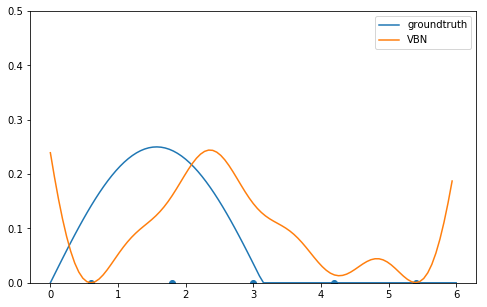

In [310]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(np.linspace(0,6,100),[0.25*np.sin(xxx) if xxx<np.pi else 0 for xxx in np.linspace(0,6,100)],label='groundtruth')
axs.plot(f[0],phi_var_full,label='VBN')
plt.legend()
axs.scatter(xi,np.zeros((len(xi))),marker='o')
plt.ylim(0,0.5)
plt.show()

In [554]:
def MISD(points_hawkes,T,T_gamma,delta_t,num_iter):
    num_g=int(T_gamma/delta_t)
    N=len(points_hawkes)
    P=ini_P(points_hawkes,T_gamma)
    g=np.zeros((1,num_g), dtype=float)

    for k in range(num_iter):
        for m in range(num_g): # update for u and g
            rate_prob=np.zeros((1,N))
            div_num=0
            for i in range(N):
                if (T-points_hawkes[i])>=m*delta_t and (T-points_hawkes[i])<(m+1)*delta_t: # point i is close to T
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/(T-m*delta_t)
                elif (T-points_hawkes[i])<m*delta_t:
                    break
                else:
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/delta_t
            if div_num==0:
                break
            else:
                g[0][m]=sum(rate_prob[0])/div_num
        u=sum(P[i][i] for i in range(N))/T

        for i in range(N): # updata for P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: continue
                intensity_total+=g[0][int(tji/delta_t)]
            intensity_total+=u
            P[i][i]=u/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: P[i][j]=0
                else: P[i][j]=g[0][int(tji/delta_t)]/intensity_total
    return u,g[0]

In [574]:
u_misd_10_list=[]
phi_misd_10_list=[]

In [575]:
for i in range(10):
    u_misd_10,phi_misd_10=MISD(points_hawkes[i],T,T_phi,0.6,100)
    u_misd_10_list.append(u_misd_10)
    phi_misd_10_list.append(phi_misd_10)

In [576]:
u_misd_10_ave=np.average(u_misd_10_list)
phi_misd_10_ave=np.average(phi_misd_10_list,axis=0)

In [602]:
u_misd_10_ave

1.0394822404183315

In [577]:
u_misd_20_list=[]
phi_misd_20_list=[]

In [578]:
for i in range(10):
    u_misd_20,phi_misd_20=MISD(points_hawkes[i],T,T_phi,0.3,100)
    u_misd_20_list.append(u_misd_20)
    phi_misd_20_list.append(phi_misd_20) 

In [579]:
u_misd_20_ave=np.average(u_misd_20_list)
phi_misd_20_ave=np.average(phi_misd_20_list,axis=0)

In [603]:
u_misd_20_ave

0.8613132867314205

In [580]:
def hawkes_second_stats_conti_gauss(t,h,points_hawkes,T):   # gaussian kernel
    N=len(points_hawkes)
    Lamda=N/T
    g_t_i=[]
    for i in range(N):
        if points_hawkes[i]+t>T-h:
            break
        else:
            g_t=np.exp(-(((t-(points_hawkes[:i]+points_hawkes[i+1:]-points_hawkes[i]))/h)**2/2))
            g_t_i.append(sum(g_t)/np.sqrt(2*np.pi)/h)
    return np.average(g_t_i)-Lamda

In [581]:
def primitive_g(t,g,range_g): # -infinity to t
    delta_t=range_g/len(g)
    num_bin=t/delta_t
    if num_bin<len(g):
        integral=sum(g[:int(num_bin)])*delta_t+g[int(num_bin)]*delta_t*(num_bin-int(num_bin))
    else:
        integral=sum(g)*delta_t
    return integral+sum(g)*delta_t

In [582]:
def gq_points_weights(a,b,Q):
    p,w=np.polynomial.legendre.leggauss(Q)
    c = np.array([0]*Q + [1])
    p_new=(a+b+(b-a)*p)/2
    w_new=(b-a)/(legendre.legval(p, legendre.legder(c))**2*(1-p**2))
    return p_new,w_new

In [583]:
def phi_WH_prediction(t,g,Q,range_g): 
    delta_t=range_g/len(g) 
    p,w=gq_points_weights(0,range_g,Q)  # (0,infininty) replaced by (0,range_g)
    g_ti=np.zeros((Q,Q))
    G_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        G_ti[i]=primitive_g(p[i],g,range_g)
        for j in range(i,Q):
            if i==j:
                g_ti[i][i]=g[int(p[i]/delta_t)]
            else:
                g_ti[i][j]=g[int((p[j]-p[i])/delta_t)]
                g_ti[j][i]=g_ti[i][j]
    
    a = np.zeros((Q,Q))
    b = np.zeros((1,Q))[0]
    for i in range(Q):
        b[i]=g_ti[i][i]
        for j in range(Q):
            if i==j:
                a[i][i]=1+G_ti[i]-sum(w*g_ti[i])+w[i]*g_ti[i][i]  #diagonal
            else:
                a[i][j]=w[j]*g_ti[i][j]    
    phi_ti = np.linalg.solve(a,b)

    g_t=g[int(t/delta_t)]
    G_t=primitive_g(t,g,range_g)
    g_t_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        g_t_ti[i]=g[int((t-p[i])/delta_t)]
    phi_t=(g_t-sum(w*phi_ti*g_t_ti))/(1+G_t-sum(w*g_t_ti))
    return phi_t

In [584]:
def phi_parameter(x,points_hawkes,h,Q,range_g):# default range_g*10 points
#     x=np.linspace(0.1/2,range_g-0.1/2,range_g*10)
    g_gauss=[hawkes_second_stats_conti_gauss(x_i,h,points_hawkes,T) for x_i in x]
    phi_result=[phi_WH_prediction(xi,g_gauss,Q,range_g) for xi in x]
    
#     mse=sum((np.array(phi_result)-1*np.exp(-2*x))**2)/(range_g*10)
    return phi_result

In [593]:
u_wh_list=[]
phi_wh_list=[]

In [594]:
for i in range(10):
    phi_wh=phi_parameter(f[0],points_hawkes[i],0.7,100,T_phi)
    u_wh=len(points_hawkes[i])/T*(1-sum(T_phi/len(f[0])*np.array(phi_wh)))
    u_wh_list.append(u_wh)
    phi_wh_list.append(phi_wh)

In [595]:
u_wh_ave=np.average(u_wh_list)
phi_wh_ave=np.average(phi_wh_list,axis=0)

In [604]:
u_wh_ave

1.3570126450393163

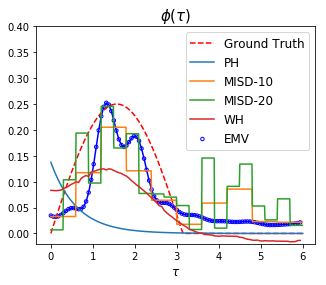

In [647]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(np.linspace(0,6,100),[0.25*np.sin(xxx) if xxx<np.pi else 0 for xxx in np.linspace(0,6,100)],'r--',label='Ground Truth')
axs.plot(f[0],phi_var_list[4],'b')
axs.scatter(f[0],phi_var_list[4],marker='o',s=12,c='',edgecolors='b',label='EMV')
axs.plot(np.linspace(0,6,100),res_ave[1]*np.exp(-res_ave[2]*np.linspace(0,6,100)),'-',label='PH')
axs.plot(np.linspace(0,6,600,endpoint=False),[phi_misd_10_ave[int(xxx/0.6)] for xxx in np.linspace(0,6,600,endpoint=False)],label='MISD-10')
axs.plot(np.linspace(0,6,600,endpoint=False),[phi_misd_20_ave[int(xxx/0.3)] for xxx in np.linspace(0,6,600,endpoint=False)],label='MISD-20')
axs.plot(f[0],phi_wh_ave,label='WH')
plt.xlabel(r'$\tau$',fontsize=12)
plt.title(r'$\phi(\tau)$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim(-0.02,0.4)
plt.savefig('c:/Users/zho045/Desktop/phi_case_3',bbox_inches = 'tight')
plt.show()

In [616]:
sum((np.array([0.25*np.sin(x) if x<np.pi else 0 -res_ave[1]*np.exp(-res_ave[2]*x) for x in f[0]]))**2*(T_phi/len(f[0])))

0.09817487054614044

In [617]:
sum((np.array([0.25*np.sin(x) if x<np.pi else 0 for x in f[0]])-phi_var_list[4])**2*(T_phi/len(f[0])))

0.013993896501875127

In [618]:
sum((np.array([0.25*np.sin(x) if x<np.pi else 0 for x in f[0]])-phi_wh_ave)**2*(T_phi/len(f[0])))

0.026587144770022456

In [619]:
sum((np.array([0.25*np.sin(x) if x<np.pi else 0 for x in f[0]])-(np.array([phi_misd_10_ave[int(xxx/0.6)] for xxx in f[0]])))**2*(T_phi/len(f[0])))

0.021269903304183654

In [620]:
sum((np.array([0.25*np.sin(x) if x<np.pi else 0 for x in f[0]])-(np.array([phi_misd_20_ave[int(xxx/0.3)] for xxx in f[0]])))**2*(T_phi/len(f[0])))

0.030820717103502718

In [626]:
(res_ave[0]-1)**2*T

3.960642618294493

In [627]:
(u_misd_10_ave-1)**2*T

0.1558847308450928

In [628]:
(u_misd_20_ave-1)**2*T

1.9234004437241188

In [629]:
(u_wh_ave-1)**2*T

12.745802871796885

In [644]:
(mu_var_list[4]-1)**2*T

5.738212505102989

## test loglikelihood

In [631]:
def intensity_discrete(t,history,u,g_mean,T_phi):    #left continue, the intensity is a gaussian dist
    mu=u
    N=len(g_mean)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<T_phi:
            intensity_mean+=g_mean[int(delta_t*N/T_phi)]
    return mu+intensity_mean

In [632]:
def negtiveloglikelihood_discrete(u,g_mean,times,T_phi,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete(times[i],times,u,g_mean,T_phi))
        delta_t=T-times[i]
        if delta_t>=T_phi:
            logl-=sum(g_mean*T_phi/M)
        else:
            temp=(delta_t)*M/T_phi
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*T_phi/M)+g_mean[temp_int]*T_phi/M*(temp-temp_int)
    return -(logl-u*T)

In [486]:
points_hawkes_test=[]
for i in range(10):
    points_hawkes_test.append(hawkes_simulation_sin(T,[1,0.25]))

In [633]:
logLik_PH=[]
for i in range(10):
    logLik_PH.append(-negtiveloglikelyhood1(res_ave, points_hawkes_test[i], T))

In [634]:
np.average(logLik_PH)

-70.18431348629689

In [635]:
logLik_misd_10=[]
for i in range(10):
    logLik_misd_10.append(-negtiveloglikelihood_discrete(u_misd_10_ave,phi_misd_10_ave,points_hawkes_test[i],T_phi,T))

In [636]:
np.average(logLik_misd_10)

-51.66374820916641

In [637]:
logLik_misd_20=[]
for i in range(10):
    logLik_misd_20.append(-negtiveloglikelihood_discrete(u_misd_20_ave,phi_misd_20_ave,points_hawkes_test[i],T_phi,T))

In [638]:
np.average(logLik_misd_20)

-51.59388368949268

In [639]:
logLik_wh=[]
for i in range(10):
    logLik_wh.append(-negtiveloglikelihood_discrete(u_wh_ave,phi_wh_ave,points_hawkes_test[i],T_phi,T))

In [640]:
np.average(logLik_wh)

-53.1538611044562

In [641]:
logLik_var=[]
for i in range(10):
    logLik_var.append(-negtiveloglikelihood_discrete(mu_var_list[4],phi_var_list[4],points_hawkes_test[i],T_phi,T))

In [642]:
np.average(logLik_var)

-51.44034552948333